<a href="https://colab.research.google.com/github/alanapaulamota/AnaliseDeSentimentos_Boost/blob/main/boost_scrap_analiseDeSentimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de sentimento sobre Rejuvenescimento de Software -
### Dados retirados do Boost por meio de Scraping

In [ ]:
#IMPORTAR DEPENDENCIAS/BIBLIOTECAS
import logging
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from wordcloud import WordCloud
from tabulate import tabulate
import matplotlib.pyplot as plt

In [ ]:
# Configurar o logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.basicConfig(level=logging.ERROR)

In [ ]:
# Baixar os recursos necessários do NLTK
try:
    nltk.download('vader_lexicon')
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('maxent_ne_chunker')
    nltk.download('words')
    nltk.download('omw')
    nltk.download('wordnet')
except Exception as e:
    logging.error(f"Error occurred while downloading NLTK resources: {str(e)}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Carregando as stopwords
try:
    stop_words = set(stopwords.words('english'))
except Exception as e:
    logging.error(f"Error occurred while loading stopwords: {str(e)}")

In [ ]:
# Cria uma instância do SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
# Cria uma instância do WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
#IMPORTAR ARQUIVOS LOCAIS
from google.colab import files
uploaded = files.upload()

Saving scrap_filter.csv to scrap_filter.csv


### Aplicando técnicas de processamento de NLP






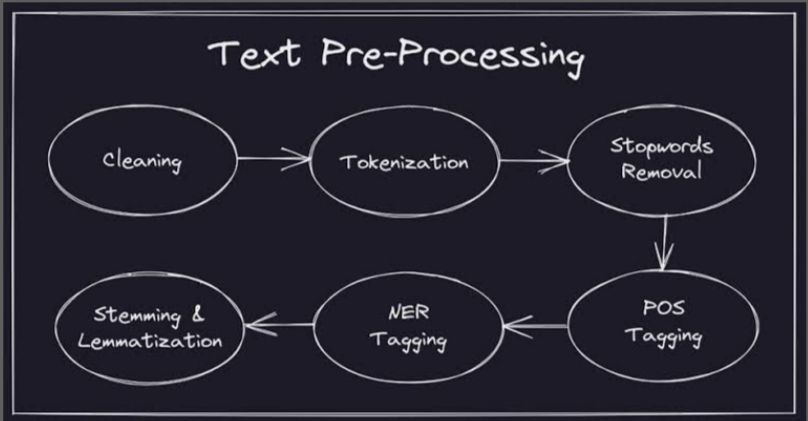

In [ ]:
def carregar_dados():
    try:
        with open("scrap_filter.csv", "r") as file:
            database = pd.read_csv(file, error_bad_lines=False)
        return database
    except FileNotFoundError:
        logging.error("scrap_filter.csv' não encontrado.")
        return None
    except Exception as e:
        logging.error(f"Erro ao carregar dados: {str(e)}")
        return None

In [ ]:
def preprocessar_texto(texto):
    try:
        # Tokenização
        tokens = word_tokenize(texto)

        # Remoção de stopwords e caracteres não alfanuméricos
        tokens = [token.lower() for token in tokens if token.isalnum() and token.lower() not in stop_words]

        # POS tagging
        pos_tags = pos_tag(tokens)

        # NER tagging
        ner_tags = ne_chunk(pos_tags)

        # Lematização
        lemmas = [lemmatizer.lemmatize(token, pos=tag[0].lower())
        if tag[0].lower() in ['a', 'n', 'v'] else lemmatizer.lemmatize(token) for token, tag in zip(tokens, pos_tags)]

        return ' '.join(lemmas)
    except Exception as e:
        logging.error(f"Error occurred while normalizing text: {str(e)}")

In [ ]:
# Função para determinar o tipo de sentimento
def tipo_sentimento(score):
    try:
        if score > 0:
            return 'positivo'
        elif score < 0:
            return 'negativo'
        else:
            return 'neutro'
    except Exception as e:
        logging.error(f"Error occurred while determining sentiment type: {str(e)}")
        return ''

In [ ]:
# Função para truncar o texto
def truncate_text(text, max_length):
    try:
        if isinstance(text, str) and len(text) > max_length:
            return f"{text[:max_length]}..."
        return text
    except Exception as e:
        logging.error(f"Error occurred while truncating text: {str(e)}")
        return text

### Processando dados

In [ ]:
#  Função para processar os dados
def processar_dados():
    try:
        # Carrega os dados do arquivo
        database = carregar_dados()

        if database is None:
            return None

        # Tratar valores ausentes
        database = database.dropna()

        # Pré-processamento de texto: Normalização
        database['processed_text'] = database['body'].apply(preprocessar_texto)

        # Define o tamanho máximo da coluna 'body'
        max_caracteres_body = 100

        # Truncar o texto da coluna 'body' para o número máximo de caracteres
        database['body'] = database['body'].apply(lambda texto: texto[:max_caracteres_body])

        # Crie uma nova coluna para armazenar as pontuações de sentimento
        database['sentimento'] = database['body'].apply(lambda texto: sia.polarity_scores(texto)['compound'])

        # Selecionar apenas as colunas 'body' e 'sentimento'
        dados_selecionados = database[['body', 'sentimento']]

        # Adicionar a coluna 'sentimento_tipo'
        dados_selecionados['sentimento_tipo'] = dados_selecionados['sentimento'].apply(tipo_sentimento)

        return dados_selecionados
    except Exception as e:
        logging.error(f"Error occurred while processing data: {str(e)}")

In [ ]:
# Função para exibir a tabela de dados
def exibir_tabela(dados, num_linhas):
    try:
        headers = ['Texto', 'Sentimento', 'Tipo']
        tabela = dados.head(num_linhas)
        tabela_formatada = tabulate(tabela, headers=headers, tablefmt='psql')
        print(tabela_formatada)
    except Exception as e:
        logging.error(f"Error occurred while displaying data table: {str(e)}")

### Quantidade de Posts positivos, negativos e neutros

In [ ]:
# Função para exibir a quantidade de posts por tipo de sentimento
def exibir_quantidades(dados):
    try:
        quantidade_positivos = dados[dados['sentimento_tipo'] == 'positivo'].shape[0]
        quantidade_neutros = dados[dados['sentimento_tipo'] == 'neutro'].shape[0]
        quantidade_negativos = dados[dados['sentimento_tipo'] == 'negativo'].shape[0]

        print("---------------------------------------------------------------------\n\n\n")
        print("Quantidade de posts positivos:", quantidade_positivos)
        print("Quantidade de posts neutros:", quantidade_neutros)
        print("Quantidade de posts negativos:", quantidade_negativos)
        print("---------------------------------------------------------------------\n\n\n")

        # Configuração do gráfico
        tipos = ['Positivos', 'Neutros', 'Negativos']
        quantidades = [quantidade_positivos, quantidade_neutros, quantidade_negativos]

        plt.bar(tipos, quantidades)
        plt.title('Quantidade de Posts por Sentimentos')
        plt.xlabel('Sentimentos')
        plt.ylabel('Quantidades')
        plt.show()
    except Exception as e:
        logging.error(f"Error occurred while displaying sentiment quantities: {str(e)}")

In [ ]:
def criar_nuvem_palavras(dados):
    try:
        # Combinar todos os textos em um único string
        text_combined = ' '.join(dados['body'])

        # Retirar palavras-chave da nuvem de palavras
        STOPWORDS = set(['Vicente', 'Botet', 'Walker', 'Niebler', 'Thomas', 'Heller', 'Giovanni', 'Piero', 'Daniel', 'Dimov', 'Abrahams', 'Larry', 'Evans', 'Mathias', 'Gaunard', 'John',
                    'Maddock', 'Escriba', 'Beman', 'Dawe', 'Edward', 'Diener', 'David', 'Michael', 'Berri', 'James', 'Semashev', 'Andrzej', 'Krzemienski', 'Douglas', 'Lorenzo',
                    'Caminiti', 'Gennadiy', 'Rozental', 'Andrey', 'Olaf', 'Antony', 'Polukhin', 'Guzman', 'Eric', 'Thorsten', 'Ottosen', 'van', 'der', 'Gavin', 'Lambert', 'Steven',
                    'Watanabe', 'Robert', 'Ramey', 'Dionne', 'Peter', 'Jeffrey', 'Lee', 'Deretta', 'Roland', 'Bock', 'Niall', 'Dougla', 'Niebler', 'Louis', 'Glen', 'Fernandes',
                    'Vladimir', 'Prus', 'Oliver', 'Kowalke', 'Hartmut', 'Kaiser', 'Vinnie', 'Falco', 'Paul', 'Fultz', 'Emil', 'Dotchevski', 'Dean', 'Joel', 'Dawes', 'Marshall',
                    'Clow', 'Dave', 'Hellrung', 'Jr', 'botet_at_', 'Nathan', 'Ridge', 'Rob', 'Stewart', 'Rene', 'Rivera', 'dave_at_', 'pdimov_at_', 'Alexander', 'Matt', 'Stefan',
                    'Gregor', 'Jonathan', 'Adam', 'Jeff', 'Berris', 'Zach', 'Laine', 'Aleksey', 'Gurtovoy', 'Michel', 'Morin', 'degski', 'eric_at_', 'semashev_at_', 'bdawes_at_',
                    'f', 'Ã', 'b', 'um', 'g', 'te', 'u', 'r', 'l', 'e', 'Ye', 'ww', 'x', 'h', 'J', 'K', 'v', 'th', 'p', 'n', 'W', 'M', 'd', 'T', 'johnny', 'simon'])

        # Tokenização
        tokens = word_tokenize(text_combined)

        # Remoção de stopwords e caracteres não alfanuméricos
        tokens = [token.lower()
                  for token in tokens
                  if token.isalnum() and token.lower() not in stop_words and token.lower() not in STOPWORDS]

        # Contagem das palavras
        word_count = {}
        for token in tokens:
            if token in word_count:
                word_count[token] += 1
            else:
                word_count[token] = 1

        # Filtrar palavras repetidas
        filtered_words = [word for word, count in word_count.items() if count == 1]

        # Criar a nuvem de palavras apenas com as palavras filtradas
        text_filtered = ' '.join(filtered_words)
        wordcloud = WordCloud(width=1600, height=800, random_state=42, collocations=True, scale=2, stopwords=STOPWORDS, prefer_horizontal=0.9).generate(text_filtered)

        # Plotar a nuvem de palavras
        plt.figure(figsize=(20, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    except Exception as e:
        logging.error(f"Error occurred while creating word cloud: {str(e)}")




---
# Função Main


### Imprimindo Resultados - Gráficos e Tabelas

In [ ]:
# Função principal
def main():
    try:
        # Processar os dados
        dados = processar_dados()

        # Exibir a tabela de dados
        exibir_tabela(dados, num_linhas=10)

        # Exibir as quantidades de posts por tipo de sentimento
        exibir_quantidades(dados)
        print("---------------------------------------------------------------------\n\n\n")

        # Criar a nuvem de palavras
        criar_nuvem_palavras(dados)
    except Exception as e:
        logging.error(f"Error occurred in main function: {str(e)}")

<ipython-input-82-22c8984636d6>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  database = pd.read_csv(file, error_bad_lines=False)
Skipping line 1207: expected 6 fields, saw 7
Skipping line 2857: expected 6 fields, saw 7
Skipping line 3649: expected 6 fields, saw 7
Skipping line 4329: expected 6 fields, saw 7
Skipping line 7038: expected 6 fields, saw 7
Skipping line 7417: expected 6 fields, saw 7
Skipping line 7869: expected 6 fields, saw 7
Skipping line 8447: expected 6 fields, saw 7
Skipping line 9309: expected 6 fields, saw 7
Skipping line 9970: expected 6 fields, saw 7
Skipping line 11011: expected 6 fields, saw 7
Skipping line 11334: expected 6 fields, saw 7
Skipping line 11846: expected 6 fields, saw 7
Skipping line 13206: expected 6 fields, saw 7

<ipython-input-86-67545d4ccdc8>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

+----+------------------------------------------------------------------------------------------------------+--------------+----------+
|    | Texto                                                                                                |   Sentimento | Tipo     |
|----+------------------------------------------------------------------------------------------------------+--------------+----------|
|  0 | Le 17/01/12 16:19, JÃ¼rgen Hunold a Ã©crit : > Hi Vicente, > > On Monday, 16. January 2012 19:51:21  |       0      | neutro   |
|  1 | >> Most web browsers don't render modern static websites with AJAX, >> accessibility, mobile renderi |       0      | neutro   |
|  2 | David Abrahams <david.abrahams_at_[hidden]> writes:                                                  |      -0.34   | negativo |
|    | > Oscar, > > That warning is a gcc bug. I can gi                                                     |              |          |
|  3 | > On Feb 12, 2018, at 7:57 PM, Zach Laine

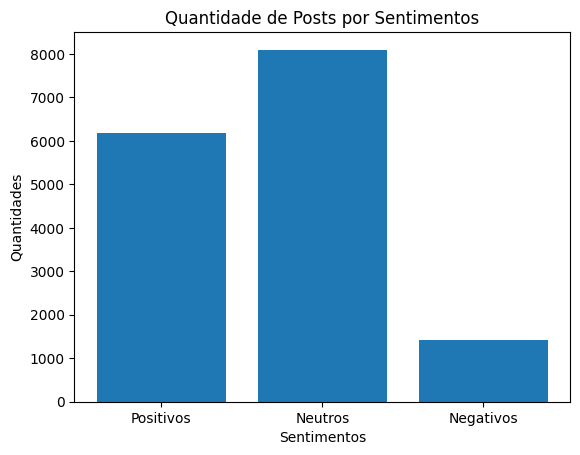

---------------------------------------------------------------------


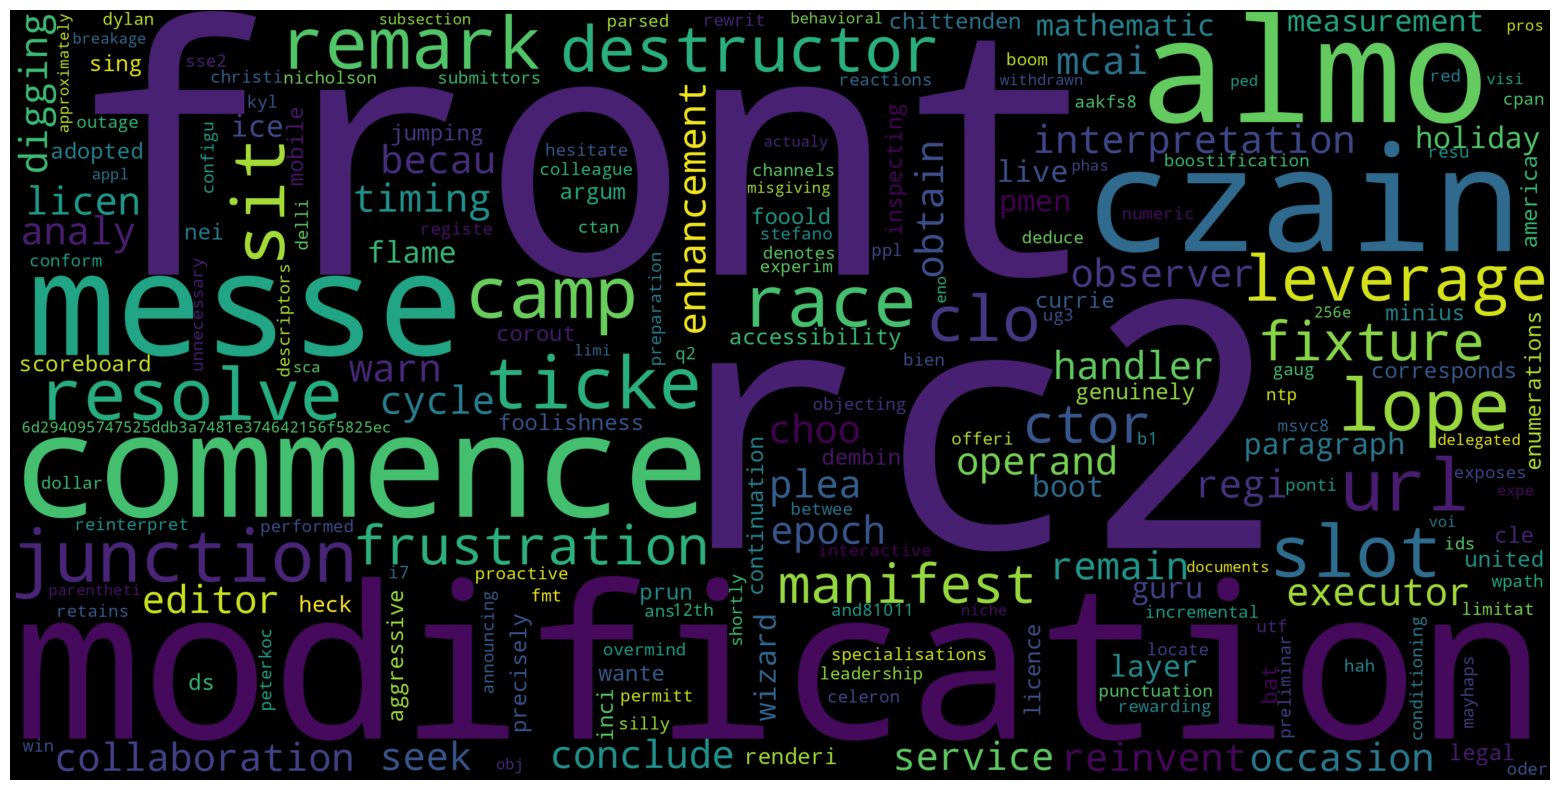

In [ ]:
# Executar o Main
if __name__ == "__main__":
    main()